#### Project 3:  Illinois Liquor Sales

#### Scenario 1: State tax board

You are a data scientist in residence at the Iowa State tax board. The Iowa State legislature is considering changes in the liquor tax rates and wants a report of current liquor sales by county and projections for the rest of the year.  (Download data from: [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy))

**Goals:** 

* Calculate the yearly liquor sales for each store using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable (it may help to use a groupby or pivot table, since you'll use this table to build your model).
* Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of each store. You must use the sales from Jan to March per store as one of your variables.
* Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016.
* Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature.
* Use cross-validation to check how your model predicts to held out data compared to the model metrics on the full dataset.
* _Challenging Bonus_: We did not cover the topics of regularization for linear regression this week, but those feeling bold can try to use and understand regularizing linear regressions. This will require self-guided research/reading and scikit-learn functions that we have not gone over in class! Use cross-validation to tune the regularization parameter that maximizes R^2 on your holdout sets for the Ridge regression and the Lasso Regression. Do the regularized models perform better than the non-regularized model? Which regularized model performs better? What is the Ridge regression doing? What is the Lasso doing.

In [1]:
import pandas as pd
import plotly as py
% matplotlib inline

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
import sklearn
from sklearn import datasets, linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score

Let's import the smaller dataset:

In [2]:
sales_orig = pd.read_csv("/Users/Rebecca/DSI-projects/projects/project-03/Iowa_Liquor_sales_sample_10pct.csv")
sales = sales_orig.copy() # keep original just in case

In [3]:
sales.head(1)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38


In [4]:
sales.dtypes

Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [5]:
# convert 'Date' column to datetime format

sales['Date'] = pd.to_datetime(sales['Date'], infer_datetime_format = True)

In [6]:
del sales['County Number'] # let's just keep ZIP code; these geographical columns contain a lot of same information
del sales['County'] # same
del sales['City'] # same
del sales['Category']  # let's use 'Category Name' instead 
del sales['Item Number']  # we'll just stick with category data, this is very specific
del sales['Item Description'] # same
del sales['Volume Sold (Gallons)'] # no one wants gallons
del sales['Volume Sold (Liters)'] # can be calculated from other columns -- so can 'Sale (Dollars)' but it's our target

In [7]:
# change dollar-value columns to floats

sales['State Bottle Cost'] = sales['State Bottle Cost'].apply(lambda x: float(x.replace('$', '')))
sales['State Bottle Retail'] = sales['State Bottle Retail'].apply(lambda x: float(x.replace('$', '')))
sales['Sale (Dollars)'] = sales['Sale (Dollars)'].apply(lambda x: float(x.replace('$', '')))

In [8]:
# rename columns 

sales.rename(columns={'Category Name':'category'}, inplace=True)
sales.rename(columns={'Bottle Volume (ml)':'volume'}, inplace=True) # this remails in mL units (no label)
sales.rename(columns={'Store Number':'store'}, inplace=True)
sales.rename(columns={'Date':'date'}, inplace=True)
sales.rename(columns={'Zip Code':'ZIP'}, inplace=True)
sales.rename(columns={'State Bottle Cost':'cost'}, inplace=True)
sales.rename(columns={'State Bottle Retail':'retail'}, inplace=True)
sales.rename(columns={'Vendor Number':'vendorID'}, inplace=True)
sales.rename(columns={'Bottles Sold':'number_sold'}, inplace=True)
sales.rename(columns={'Sale (Dollars)':'total_sale'}, inplace=True)

In [9]:
# fix remaining data types that still do not look right

sales['store'] = sales['store'].apply(lambda x: str(x))
sales['vendorID'] = sales['vendorID'].apply(lambda x: str(x))
sales['volume'] = sales['volume'].apply(lambda x: float(x))
sales['number_sold'] = sales['number_sold'].apply(lambda x: float(x))

In [10]:
sales.dtypes

date           datetime64[ns]
store                  object
ZIP                    object
category               object
vendorID               object
volume                float64
cost                  float64
retail                float64
number_sold           float64
total_sale            float64
dtype: object

In [11]:
print 'Number of unique...'
print 'Observations:    %s' %len(sales)
print 'Stores:          %s' %len(sales['store'].unique())
print 'ZIP codes:       %s' %len(sales['ZIP'].unique())
print 'Item categories: %s' %len(sales['category'].unique())
print 'Vendors:         %s' %len(sales['vendorID'].unique())
print 'Bottle volumes:  %s' %len(sales['volume'].unique())

Number of unique...
Observations:    270955
Stores:          1400
ZIP codes:       415
Item categories: 72
Vendors:         116
Bottle volumes:  29


In [12]:
len(sales['category'].unique())

72

In [13]:
# that's a lot of categories!  let's have a look and try to consolidate some of them

sales['category'].value_counts()

VODKA 80 PROOF                        35373
CANADIAN WHISKIES                     27087
STRAIGHT BOURBON WHISKIES             15342
SPICED RUM                            14631
VODKA FLAVORED                        14001
TEQUILA                               12109
BLENDED WHISKIES                      11547
WHISKEY LIQUEUR                       10902
IMPORTED VODKA                        10668
PUERTO RICO & VIRGIN ISLANDS RUM      10062
FLAVORED RUM                           7282
TENNESSEE WHISKIES                     7081
AMERICAN COCKTAILS                     6929
AMERICAN GRAPE BRANDIES                6589
AMERICAN DRY GINS                      6559
IMPORTED VODKA - MISC                  6506
MISC. IMPORTED CORDIALS & LIQUEURS     6299
CREAM LIQUEURS                         6284
SCOTCH WHISKIES                        5375
IMPORTED GRAPE BRANDIES                4614
IMPORTED SCHNAPPS                      4249
MISC. AMERICAN CORDIALS & LIQUEURS     3394
100 PROOF VODKA                 

In [14]:
# consolidating...

sales['category'] = sales['category'].apply(lambda x: str(x))
sales['category'] = sales['category'].apply(lambda x: x.replace('VODKA 80 PROOF', 'VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('CANADIAN WHISKIES', 'WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('STRAIGHT BOURBON WHISKIES', 'BOURBON'))
sales['category'] = sales['category'].apply(lambda x: x.replace('VODKA FLAVORED', 'VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('BLENDED WHISKIES', 'WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('WHISKEY LIQUEUR', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('PUERTO RICO & VIRGIN ISLANDS RUM', 'RUM'))
sales['category'] = sales['category'].apply(lambda x: x.replace('FLAVORED RUM', 'RUM'))
sales['category'] = sales['category'].apply(lambda x: x.replace('TENNESSEE WHISKIES', 'WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('SPICED RUM', 'RUM'))
sales['category'] = sales['category'].apply(lambda x: x.replace('AMERICAN GRAPE BRANDIES', 'BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('AMERICAN DRY GINS', 'GIN'))
sales['category'] = sales['category'].apply(lambda x: x.replace('IMPORTED VODKA - MISC', 'IMPORTED VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('MISC. IMPORTED CORDIALS & LIQUEURS', 'IMPORTED CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('CREAM LIQUEURS', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('SCOTCH WHISKIES', 'WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('IMPORTED GRAPE BRANDIES', 'IMPORTED BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('MISC. AMERICAN CORDIALS & LIQUEURS', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('100 PROOF VODKA ', 'VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('IMPORTED DRY GINS', 'IMPORTED GIN'))
sales['category'] = sales['category'].apply(lambda x: x.replace('IRISH WHISKIES', 'IMPORTED WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('WATERMELON SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('BARBADOS RUM', 'IMPORTED RUM'))
sales['category'] = sales['category'].apply(lambda x: x.replace('JAMAICA RUM', 'IMPORTED RUM'))
sales['category'] = sales['category'].apply(lambda x: x.replace('GRAPE SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('CHERRY BRANDIES', 'BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('ROOT BEER SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('RASPBERRY SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('COFFEE LIQUEURS', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('PEACH SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('BLACKBERRY BRANDIES', 'BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('IMPORTED AMARETTO', 'IMPORTED CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('GREEN CREME DE MENTHE', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('FLAVORED GINS', 'GIN'))
sales['category'] = sales['category'].apply(lambda x: x.replace('TROPICAL FRUIT SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('WHITE CREME DE CACAO', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('DARK CREME DE CACAO', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('BOTTLED IN BOND BOURBON', 'BOURBON'))
sales['category'] = sales['category'].apply(lambda x: x.replace('SINGLE BARREL BOURBON WHISKIES', 'BOURBON'))
sales['category'] = sales['category'].apply(lambda x: x.replace('AMERICAN SLOE GINS', 'GIN'))
sales['category'] = sales['category'].apply(lambda x: x.replace('MISCELLANEOUS  BRANDIES', 'BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('SPEARMINT SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('ROCK & RYE', 'WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('WHITE CREME DE MENTHE', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('CREME DE ALMOND', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('ANISETTE', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('JAPANESE WHISKY', 'IMPORTED VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('LOW PROOF VODKA', 'VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('CORN WHISKIES', 'WHISKEY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('AMARETTO - IMPORTED', 'IMPORTED CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('HIGH PROOF BEER - AMERICAN', 'BEER'))
sales['category'] = sales['category'].apply(lambda x: x.replace('CINNAMON SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('APPLE SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('TRIPLE SEC', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('BUTTERSCOTCH SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('MISCELLANEOUS SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('100 PROOF VODKA', 'VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('PEPPERMINT SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('AMERICAN AMARETTO', 'CORDIAL & LIQUEUR'))
sales['category'] = sales['category'].apply(lambda x: x.replace('APRICOT BRANDIES', 'BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('PEACH BRANDIES', 'BRANDY'))
sales['category'] = sales['category'].apply(lambda x: x.replace('STRAWBERRY SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('OTHER PROOF VODKA', 'VODKA'))
sales['category'] = sales['category'].apply(lambda x: x.replace('MISCELLANEOUS SCHNAPPS', 'SCHNAPPS'))
sales['category'] = sales['category'].apply(lambda x: x.replace('STRAIGHT RYE WHISKIES', 'WHISKEY'))

In [15]:
sales['category'].value_counts()

VODKA                             52771
WHISKEY                           52576
RUM                               31975
CORDIAL & LIQUEUR                 25841
IMPORTED VODKA                    17197
BOURBON                           15851
TEQUILA                           12109
BRANDY                            10430
SCHNAPPS                          10315
GIN                                6978
AMERICAN COCKTAILS                 6929
IMPORTED CORDIAL & LIQUEUR         6578
IMPORTED BRANDY                    4614
IMPORTED SCHNAPPS                  4249
IMPORTED GIN                       2939
IMPORTED WHISKEY                   2791
SINGLE MALT SCOTCH                 2288
DISTILLED SPIRITS SPECIALTY        1380
DECANTERS & SPECIALTY PACKAGES     1159
IMPORTED RUM                        778
nan                                 632
AMERICAN ALCOHOL                    573
BEER                                  2
Name: category, dtype: int64

In [16]:
# delete rows with 'nan' entry in category column:

sales = sales[sales.category != 'nan']

In [17]:
sales['category'].value_counts()

VODKA                             52771
WHISKEY                           52576
RUM                               31975
CORDIAL & LIQUEUR                 25841
IMPORTED VODKA                    17197
BOURBON                           15851
TEQUILA                           12109
BRANDY                            10430
SCHNAPPS                          10315
GIN                                6978
AMERICAN COCKTAILS                 6929
IMPORTED CORDIAL & LIQUEUR         6578
IMPORTED BRANDY                    4614
IMPORTED SCHNAPPS                  4249
IMPORTED GIN                       2939
IMPORTED WHISKEY                   2791
SINGLE MALT SCOTCH                 2288
DISTILLED SPIRITS SPECIALTY        1380
DECANTERS & SPECIALTY PACKAGES     1159
IMPORTED RUM                        778
AMERICAN ALCOHOL                    573
BEER                                  2
Name: category, dtype: int64

In [18]:
len(sales['category'].unique())  # much better!  this will probably turn into a dummy variable

22

In [21]:
sales.head(1)

,date,store,ZIP,category,vendorID,volume,cost,retail,number_sold,total_sale
0,2015-11-04,3717,50674,BRANDY,55,750.0,4.5,6.75,12.0,81.0


In [22]:
len(sales['store'].unique()) # THIS WILL BE OUR KEY!  it is not currently acting as key because there are \
                                #multiple date entries per store

1400

In [23]:
len(sales['ZIP'].unique()) # dummy?

415

In [24]:
len(sales['vendorID'].unique()) # dummy?

115

In [25]:
sales['volume'].value_counts()

750.0     122456
1750.0     54316
1000.0     36794
375.0      26994
500.0      11967
200.0       9895
600.0       3282
3000.0      1605
300.0       1338
100.0        860
800.0        318
1200.0       250
2400.0       103
400.0         29
850.0         24
4800.0        17
50.0          14
3600.0        13
603.0         10
6000.0         7
950.0          6
2250.0         6
2550.0         6
1125.0         5
150.0          3
900.0          2
1500.0         1
250.0          1
4500.0         1
Name: volume, dtype: int64

In [26]:
# a couple of these look fishy, let's adjust by a few mLs:

sales['volume'] = sales['volume'].apply(lambda x: str(x))
sales['volume'] = sales['volume'].apply(lambda x: x.replace('603.0', '600.0'))
sales['volume'] = sales['volume'].apply(lambda x: x.replace('502.0', '500.0'))
sales['volume'] = sales['volume'].apply(lambda x: float(x))

In [27]:
sales['volume'].value_counts()

750.0     122456
1750.0     54316
1000.0     36794
375.0      26994
500.0      11967
200.0       9895
600.0       3292
3000.0      1605
300.0       1338
100.0        860
800.0        318
1200.0       250
2400.0       103
400.0         29
850.0         24
4800.0        17
50.0          14
3600.0        13
6000.0         7
950.0          6
2250.0         6
2550.0         6
1125.0         5
150.0          3
900.0          2
1500.0         1
250.0          1
4500.0         1
Name: volume, dtype: int64

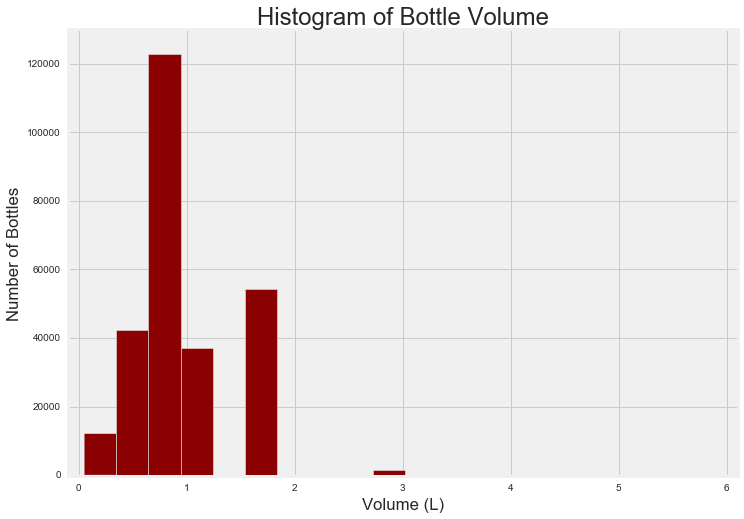

In [28]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(sales['volume']/1000, color = 'darkred', bins = 20)

plt.title('Histogram of Bottle Volume', fontsize = 24)

# y label
plt.ylabel('Number of Bottles')

# x label
plt.xlabel('Volume (L)')

plt.xlim([-0.1,6.1])
plt.ylim([-200,130000])

plt.show()

We can see from the histogram that the vast majority of bottles sold are below 2L in volume.  The most frequently purchased volume is 0.750L.

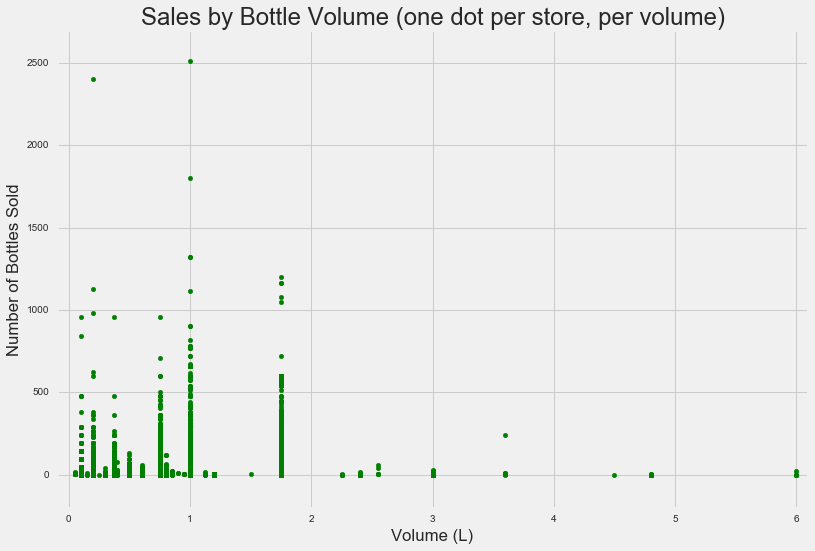

In [29]:
plt.figure(figsize=(12,8))

plt.style.use('fivethirtyeight')

plt.scatter(sales['volume']/1000, sales['number_sold'], color = 'green')

plt.title('Sales by Bottle Volume (one dot per store, per volume)', fontsize = 24)

# y label
plt.ylabel('Number of Bottles Sold')

# x label
plt.xlabel('Volume (L)')

plt.xlim([-0.1,6.1])
plt.ylim([-200,2700])

plt.show()

From the scatterplot, we see that some stores are selling way, way more bottles at a given volume that other stores.  A scatter would be useful here to see relative density of plotted points where it looks like they're stacking up.  (To note, there were some exceedingly large-volumed items which appear to have dropped out of the data set during cleaning.)

In [30]:
# let's see what's up with some of the larger volumes:

sales[sales['volume'] > 4000]

,date,store,ZIP,category,vendorID,volume,cost,retail,number_sold,total_sale
2570,2015-10-08,2587,50131,IMPORTED WHISKEY,65,4800.0,71.04,106.56,1.0,106.56
38630,2015-12-22,2500,50010,IMPORTED WHISKEY,65,4800.0,71.04,106.56,1.0,106.56
56706,2015-01-05,2636,50317,IMPORTED WHISKEY,65,4800.0,45.12,67.68,1.0,67.68
60585,2015-11-04,3987,50511,CORDIAL & LIQUEUR,305,6000.0,99.00,148.50,1.0,148.50
63818,2015-05-22,2636,50317,IMPORTED WHISKEY,65,4800.0,45.12,67.68,1.0,67.68
71636,2016-02-25,5106,52742,CORDIAL & LIQUEUR,305,6000.0,99.00,148.50,1.0,148.50
74088,2015-02-04,2500,50010,CORDIAL & LIQUEUR,308,4500.0,68.94,103.41,1.0,103.41
114946,2015-07-28,4819,50009,IMPORTED WHISKEY,65,4800.0,45.12,67.68,3.0,203.04
121877,2015-12-23,5093,52753,CORDIAL & LIQUEUR,305,6000.0,99.00,148.50,1.0,148.50
141875,2015-01-07,2603,52722,IMPORTED WHISKEY,65,4800.0,45.12,67.68,1.0,67.68


As we can see from the table above, there are two vendors selling all bottles over 4L; vendor 65 is selling some kind of whiskey and vendor 305 is selling a cordial/liqueur.  No store is buying much from either source, **except** store 233407, which bought 25 units from vendor 305.

We need to get rid of all entries for any store with NaN in 'dollars_sold' when grouped by month, because those stores likely opened or closed within the period of data collection and thus do not provide a full picture of that store's profits in that time.

In [31]:
sales['year'] = sales['date'].apply(lambda x: x.year)
sales['month'] = sales['date'].apply(lambda x: x.month)

In [32]:
get_stores = sales.groupby(['year', 'store', 'month'])['total_sale'].aggregate(sum).unstack()

In [33]:
get_stores.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

In [34]:
get_stores.index.names

FrozenList([u'year', u'store'])

In [35]:
get_stores.head()

Jan       Feb       Mar       Apr       May       Jun  \
year store                                                               
2015 2106   13567.80  12873.14  12846.35  11957.86   7526.88  11688.72   
     2113     813.68    713.59   1305.98    414.15    727.69    852.46   
     2130    7725.66   8655.08   7891.83  13738.75  13612.92   7686.42   
     2152    1096.72    589.59    317.15    231.52    783.02    384.38   
     2178    2251.52   1427.65   2177.24   1255.40   2672.73   3058.20   

                 Jul       Aug       Sep       Oct       Nov       Dec  
year store                                                              
2015 2106   15764.34  12329.82  10230.61  16899.33  10688.38   9665.47  
     2113     782.97    184.47   1146.12    862.29    397.05   1109.77  
     2130   10137.66   5955.66   8512.56  11169.32   5072.91  11425.14  
     2152     877.10    971.09    398.51    937.63    504.88    629.49  
     2178    1326.52   1369.37   2972.26   1735.26   1372.99   2705.04

In [36]:
stores_2015 = get_stores.loc[2015]
stores_2016 = get_stores.loc[2016]

In [37]:
stores_2015 = stores_2015.dropna()

In [38]:
new_index = stores_2015.index
stores_2016 = stores_2016[stores_2016.index.isin(new_index)]
newer_index = stores_2016.index
stores_2015 = stores_2015[stores_2015.index.isin(newer_index)]

In [39]:
stores_2015['total'] = stores_2015.sum(axis = 1)
stores_2016['total'] = stores_2016.sum(axis = 1)

Below we have monthly 2015 sales totals by store, with a cumulative column on the right ('total').

In [40]:
stores_2015.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total
store,,,,,,,,,,,,,
2106,13567.80,12873.14,12846.35,11957.86,7526.88,11688.72,15764.34,12329.82,10230.61,16899.33,10688.38,9665.47,146038.70
2113,813.68,713.59,1305.98,414.15,727.69,852.46,782.97,184.47,1146.12,862.29,397.05,1109.77,9310.22


Likewise, here we have the same for 2016 (for which we only have data through the first quarter).

In [41]:
stores_2016.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total
store,,,,,,,,,,,,,
2106,8472.17,12053.61,9952.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30478.75
2113,892.94,727.16,445.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2065.90


In [42]:
Q1_2015 = stores_2015[['Jan', 'Feb', 'Mar']]
Q2_2015 = stores_2015[['Apr', 'May', 'Jun']]
Q3_2015 = stores_2015[['Jul', 'Aug', 'Sep']]
Q4_2015 = stores_2015[['Oct', 'Nov', 'Dec']]

Q1_2016 = stores_2016[['Jan', 'Feb', 'Mar']]

In [43]:
Q1_2015['total'] = Q1_2015.sum(axis = 1)
Q2_2015['total'] = Q2_2015.sum(axis = 1)
Q3_2015['total'] = Q3_2015.sum(axis = 1)
Q4_2015['total'] = Q4_2015.sum(axis = 1)

Q1_2016['total'] = Q1_2016.sum(axis = 1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [44]:
# update original dataframe to include only stores we're interested in:

nice_sales = sales[sales['store'].isin(newer_index)]

In [45]:
nice_sales.head(2)

,date,store,ZIP,category,vendorID,volume,cost,retail,number_sold,total_sale,year,month
0,2015-11-04,3717,50674,BRANDY,55,750.0,4.50,6.75,12.0,81.00,2015,11
1,2016-03-02,2614,52807,WHISKEY,395,750.0,13.75,20.63,2.0,41.26,2016,3


In [46]:
del sales['date']
del sales['year']
del sales['month']

In [47]:
#pd.concat([sales.drop('category',axis=1),pd.get_dummies(sales['category'])], axis = 1)
#pd.concat([sales.drop('vendorID',axis=1),pd.get_dummies(sales['vendorID'])], axis = 1)
#pd.concat([sales.drop('ZIP',axis=1),pd.get_dummies(sales['ZIP'])], axis = 1)

In [48]:
nicer_sales = nice_sales.pivot_table(index = 'store')

In [49]:
nicer_sales.head()

,cost,month,number_sold,retail,total_sale,volume,year
store,,,,,,,
2106,10.311273,5.651840,19.283742,15.479095,270.732285,913.496933,2015.193252
2113,10.838152,5.635870,4.510870,16.267717,61.826739,954.483696,2015.201087
2130,10.006398,5.600394,18.000000,15.015197,274.488228,935.777559,2015.230315
2152,8.546550,6.052632,4.146199,12.856784,53.201813,1061.403509,2015.175439
2178,9.606576,5.749153,8.162712,14.432203,101.398915,1026.694915,2015.196610


In [50]:
nicer_sales['Q1_2015'] = Q1_2015['total']
nicer_sales['Q2_2015'] = Q2_2015['total']
nicer_sales['Q3_2015'] = Q3_2015['total']
nicer_sales['Q4_2015'] = Q4_2015['total']
nicer_sales['total_2015'] = nicer_sales.sum(axis = 1)
nicer_sales['Q1_2016'] = Q1_2016['total']

In [51]:
# something weird happens with the old float columns; let's just use quarterly data for now

del nicer_sales['cost']
del nicer_sales['number_sold']
del nicer_sales['retail']
del nicer_sales['total_sale']
del nicer_sales['volume']

In [53]:
nicer_sales.head() 
del nicer_sales['month']
del nicer_sales['year']

We'll make 'total_2015' our target variable and try to fit a model using the other columns.  

In [56]:
# target; we want to try to predict total dollars for 2016, so we use total dollars for 2015 to build model
my_y = nicer_sales['total_2015']

# independent variable
nicer_sales['intercept'] = 1
my_X = nicer_sales[['Q1_2015', 'intercept']]

In [58]:
lr = linear_model.LinearRegression()
model = lr.fit(my_X, my_y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(my_X, my_y, test_size=0.10)

print "       X Shape  Y Shape"
print "Train:", X_train.shape, y_train.shape
print "Test: ", X_test.shape,  y_test.shape

       X Shape  Y Shape
Train: (742, 2) (742,)
Test:  (83, 2) (83,)


In [63]:
predictions = lr.predict(nicer_sales[['Q1_2016', 'intercept']])

Cross validation score: [ 0.95559853  0.93551829  0.90112919  0.89274496  0.98318345]
Mean cross validation score: 0.933634882502
MSE: [ -3.68983026e+08  -2.11192687e+08  -8.90473018e+07  -1.99688776e+07
  -7.89072245e+07]


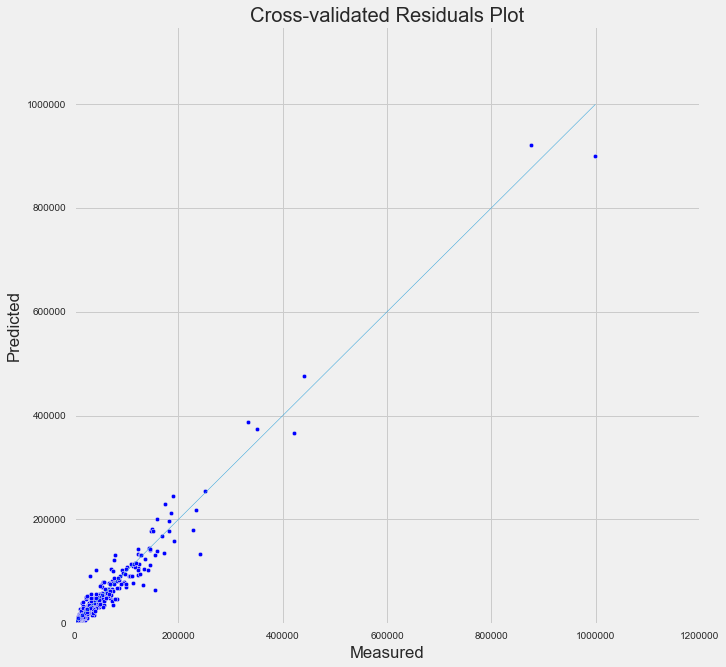

In [209]:
# cross_val_predict returns an array of the same size as `y` where each entry is a prediction obtained by cross validation:
domain = nice_sales['Q1_2015']
predicted = cross_val_predict(model, my_X, my_y, cv=825)
print 'Cross validation score: %s' %cross_val_score(lr, X, y, n_jobs=1, cv=5)
print 'Mean cross validation score: %s' %cross_val_score(lr, X, y, n_jobs=1, cv=5).mean()
print 'MSE: %s' %cross_val_score(lr, X, y, n_jobs=1, cv=5, scoring='mean_squared_error')

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], lw=0.5)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.xlim([-1000, 1200000])
plt.ylim([-1000, 1150000])
plt.title('Cross-validated Residuals Plot')
plt.show()

Coefficients: 
[ 4.46148707  0.        ]
Variance score: 0.97
Residual sum of squares: 3935881641.25
Bias: 132516289.478
Variance: 3803365351.76
R^2: 0.925205059935


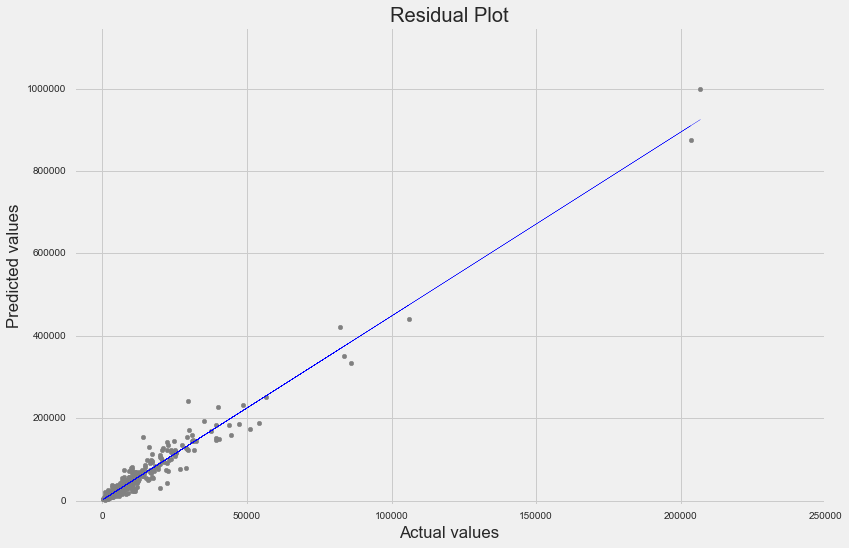

In [192]:
X = my_X
y = my_y

regr = linear_model.LinearRegression()
regr.fit(X, y)

yhat = regr.predict(X)
sse = np.mean((np.mean(yhat) - y) ** 2)
var = np.var(yhat)
bias = sse - var - 0.01

# The coefficients
print 'Coefficients: \n', regr.coef_
# Explained variance score: 1 is perfect prediction
print 'Variance score: %.2f' % regr.score(X, y)

# The mean square error
print "Residual sum of squares: %.2f" % sse

print "Bias: {bias}".format(bias=bias)
print "Variance: {var}".format(var=var)
print "R^2:", model.score(X_test, y_test) 

# Plot outputs

plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')

plt.scatter(domain, y,  color='grey')
plt.plot(domain, regr.predict(X), color='blue', linewidth=0.2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.title('Residual Plot')
plt.xlim([-10000, 250000])
plt.ylim([-10000, 1150000])

plt.show()

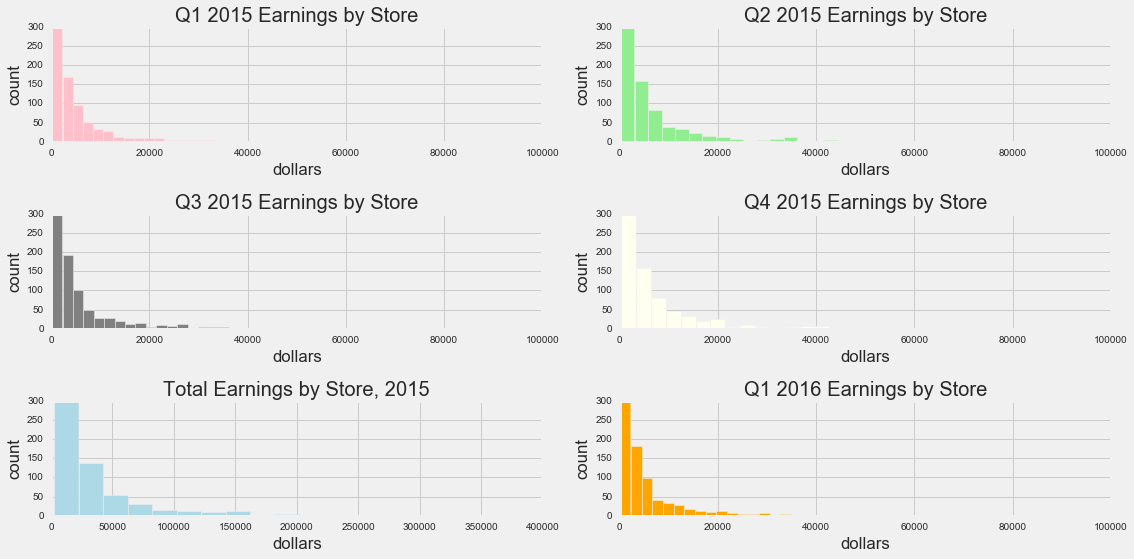

In [167]:
fig, axes = plt.subplots(3,2, figsize=(16,8))
plt.style.use('fivethirtyeight')

axes_details = type(axes)
fig_details = type(fig)

axes[0][0].hist(nice_sales['Q1_2015'], color = 'pink', bins = 100)
axes[0][0].set_xlim([0, 100000])
axes[0][0].set_ylim([0, 300])
axes[0][0].set_title('Q1 2015 Earnings by Store')
axes[0][0].set_xlabel('dollars')
axes[0][0].set_ylabel('count')

axes[0][1].hist(nice_sales['Q2_2015'], color = 'lightgreen', bins = 100)
axes[0][1].set_xlim([0, 100000])
axes[0][1].set_ylim([0, 300])
axes[0][1].set_title('Q2 2015 Earnings by Store')
axes[0][1].set_xlabel('dollars')
axes[0][1].set_ylabel('count')

axes[1][0].hist(nice_sales['Q3_2015'], color = 'grey', bins = 100)
axes[1][0].set_xlim([0, 100000])
axes[1][0].set_ylim([0, 300])
axes[1][0].set_title('Q3 2015 Earnings by Store')
axes[1][0].set_xlabel('dollars')
axes[1][0].set_ylabel('count')

axes[1][1].hist(nice_sales['Q4_2015'], color = 'ivory', bins = 100)
axes[1][1].set_xlim([0, 100000])
axes[1][1].set_ylim([0, 300])
axes[1][1].set_title('Q4 2015 Earnings by Store')
axes[1][1].set_xlabel('dollars')
axes[1][1].set_ylabel('count')

axes[2][0].hist(nice_sales['total_2015'], color = 'lightblue', bins = 50)
axes[2][0].set_xlim([0, 400000])
axes[2][0].set_ylim([0, 300])
axes[2][0].set_title('Total Earnings by Store, 2015')
axes[2][0].set_xlabel('dollars')
axes[2][0].set_ylabel('count')

axes[2][1].hist(nice_sales['Q1_2016'], color = 'orange', bins = 100)
axes[2][1].set_xlim([0, 100000])
axes[2][1].set_ylim([0, 300])
axes[2][1].set_title('Q1 2016 Earnings by Store')
axes[2][1].set_xlabel('dollars')
axes[2][1].set_ylabel('count')

plt.tight_layout()
plt.show()

In [210]:
lasso = linear_model.Lasso(alpha=1)
lasso_model = lasso.fit(my_X, my_y)
lasso_r2 =  r2_score(y_true=y, y_pred=lasso_model.predict(X))
print 'Lasso score: %s' %cross_val_score(lasso, X, y, n_jobs=1, cv=5, scoring='mean_squared_error')
print 'Lasso R^2: %s' %lasso_r2

Lasso score: [ -3.68983030e+08  -2.11192686e+08  -8.90473014e+07  -1.99688777e+07
  -7.89072240e+07]
Lasso R^2: 0.966331231077


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [6]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.